In [110]:
import numpy as np
# import cv2
import tifffile as tiff
from shapely.geometry import Polygon, mapping, shape, box
from skimage import io
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
# import json
from rasterio import features
import scanpy as sc
import pandas as pd
import geopandas as gpd

import pickle
import scipy

import seaborn as sns

from SGanalysis.SGobject import SGobject

import matplotlib
%matplotlib inline
# matplotlib.use('Qt5Agg')
# %matplotlib qt

from sklearn.cluster import AgglomerativeClustering as AggCluster

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys
import os

tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/SpatialBarcodes/analysis/tools/tools.py'

# tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:

from SGanalysis.SGobject import SGobject

In [3]:
# filepath  = '/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/Shared_Grant/SpatialBarcodes/ImagingData/2024-02-27_spatialbarcodes_SG_expression/projects/2024-02-27_spatialbarcodes_expression/'
filepath = '/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-02-27_spatialbarcodes_SG_expression/projects/2024-02-27_spatialbarcodes_expression/'


# roi_2
# roi_2
roi_name = 'roi_2'

In [123]:
# First time, I ran this to create the pickle file...

# # Create an instance of SGobject
# sg_obj = SGobject()

# # Convert a TIFF image to polygons and store them in a GeoDataFrame
# print("Running mask_to_objects...")
# sg_obj.mask_to_objects(f'{filepath}{roi_name}/segmentations/segmentation_1_nuclei.tiff')

# spot_file = f'{filepath}{roi_name}/exports/decode_20240314_withcoordinates.csv'

# sg_obj.load_points(spot_file)

# # sg_obj.dilate_objects(10)
# sg_obj.create_cell_gene_table()

# # with open(f'{filepath}{roi_name}/exports/sg_object_decode_20240314_segmentation_1_20240806_dilate10.pkl', 'wb') as f:
# #     pickle.dump(sg_obj,f)

# with open(f'{filepath}{roi_name}/exports/sg_object_decode_20240314_segmentation_1_20240806.pkl', 'wb') as f:
#     pickle.dump(sg_obj,f)


## Later instances, use the pickle file to avoid needing to 

with open(f'{filepath}{roi_name}/exports/sg_object_decode_20240314_segmentation_1_20240806.pkl', 'rb') as f:
    sg_obj = pickle.load(f)

# sg_obj 

In [8]:
# with open(f'{filepath}{roi_name}/exports/sg_object_decode_20240314_segmentation_1_20240806_dilate10.pkl', 'wb') as f:
#     pickle.dump(sg_obj,f)

# with open(f'{filepath}{roi_name}/exports/sg_object_decode_20240314_segmentation_1_20240806_dilate10.pkl', 'wb') as f:
    # pickle.dump(sg_obj,f)

# with open(f'{filepath}{roi_name}/exports/sg_object_decode_20240314_segmentation_1_20240806.pkl', 'rb') as f:
#     sg_obj = pickle.load(f)

In [126]:
df = sg_obj.get_cell_gene_table_df()

cutoff = 3

cell_barcodes = {}
# matrix.set_index('object_id',   inplace=True)
df = df.set_index('object_id')

# df = matrix

df.sort_index(inplace=True)

df['cell_id'] = df.index

No filtering available or applied.


/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_29178/755052625.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['cell_id'] = df.index


In [128]:
df = sg_obj.get_cell_gene_table_df()

cutoff = 3

cell_barcodes = {}
# matrix.set_index('object_id',   inplace=True)
df.set_index('object_id')

# df = matrix

df.sort_index(inplace=True)

df['cell_id'] = df.index

barcode_cols = ['bc_{:03d}'.format(i) for i in range(1,97)]

for cell_id in df['cell_id']:
    this_cell = df[df['cell_id']==cell_id]
    cell_barcodes[cell_id] = []

    for bc in barcode_cols:
        if this_cell[bc].values[0] > cutoff:
            cell_barcodes[cell_id].append(bc)

df['called_barcodes'] = cell_barcodes.values()
df['n_called_barcodes'] = [len(bc_set) for bc_set in cell_barcodes.values()]
df['barcode_names'] = ['-'.join(sorted(bc_set)) for bc_set in cell_barcodes.values()]

# df = pd.merge(df,sg_obj.gdf,how='left',left_index=True,right_index=True)


gene_cols = [col for col in df.columns if 'bc_' not in col and col not in ['cell_id','called_barcodes','n_called_barcodes','barcode_names']]

No filtering available or applied.


In [130]:
sg_obj.gdf

,object_id,nucleus
0,35,"POLYGON ((9279.000 2.000, 9349.000 3.000, 9356..."
1,34,"POLYGON ((6437.000 2.000, 6520.000 2.000, 6527..."
2,29,"POLYGON ((24636.000 0.000, 24762.000 0.000, 24..."
3,11,"POLYGON ((11474.000 0.000, 11542.000 0.000, 11..."
4,15,"POLYGON ((14595.000 0.000, 14678.000 2.000, 14..."
...,...,...
16371,16364,"POLYGON ((19896.000 35571.000, 19914.000 35571..."
16372,16375,"POLYGON ((20380.000 35592.000, 20408.000 35596..."
16373,16361,"POLYGON ((22881.000 35565.000, 22904.000 35566..."
16374,16357,"POLYGON ((24819.000 35560.000, 24840.000 35560..."


In [129]:
df

,object_id_x,AKT1,AXL,BGN,BIRC3,BIRC5,BMP2,BMP4,CALD1,CAPG,...,bc_093,bc_094,bc_095,bc_096,cell_id,called_barcodes,n_called_barcodes,barcode_names,object_id_y,nucleus
0,35.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0,[],0,,NaN,None
1,34.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,...,0.0,1.0,0.0,0.0,1,[],0,,NaN,None
10,13.0,2.0,0.0,0.0,0.0,7.0,0.0,0.0,6.0,22.0,...,0.0,0.0,0.0,0.0,10,"[bc_024, bc_043]",2,bc_024-bc_043,NaN,None
100,126.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,100,[],0,,NaN,None
1000,989.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,6.0,20.0,...,0.0,0.0,0.0,0.0,1000,"[bc_001, bc_035, bc_062]",3,bc_001-bc_035-bc_062,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9991.0,6.0,0.0,0.0,0.0,4.0,0.0,0.0,6.0,18.0,...,0.0,0.0,5.0,0.0,9995,"[bc_011, bc_013, bc_047, bc_048, bc_086, bc_09...",7,bc_011-bc_013-bc_047-bc_048-bc_086-bc_091-bc_095,NaN,None
9996,9993.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,11.0,28.0,...,0.0,0.0,0.0,0.0,9996,[bc_014],1,bc_014,NaN,None
9997,10003.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,53.0,...,0.0,0.0,0.0,0.0,9997,"[bc_002, bc_020, bc_033, bc_041, bc_058, bc_078]",6,bc_002-bc_020-bc_033-bc_041-bc_058-bc_078,NaN,None
9998,9988.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,29.0,...,0.0,0.0,0.0,0.0,9998,"[bc_025, bc_035]",2,bc_025-bc_035,NaN,None


In [108]:
out_path = f'{filepath}{roi_name}/exports/'

In [131]:
## traditional barcode calling (using cutoff of 3)

df = sg_obj.get_cell_gene_table_df()

cutoff = 3

cell_barcodes = {}
# matrix.set_index('object_id',   inplace=True)
df = df.set_index('object_id')

df.sort_index(inplace=True)

df['cell_id'] = df.index

for cell_id in df['cell_id']:
    this_cell = df[df['cell_id']==cell_id]
    cell_barcodes[cell_id] = []

    for bc in barcode_cols:
        if this_cell[bc].values[0] >= cutoff:
            cell_barcodes[cell_id].append(bc)

df['called_barcodes'] = cell_barcodes.values()
df['n_called_barcodes'] = [len(bc_set) for bc_set in cell_barcodes.values()]
df['barcode_names'] = ['-'.join(sorted(bc_set)) for bc_set in cell_barcodes.values()]

# df = pd.merge(df,sg_obj.gdf,how='left',left_index=True,right_index=True)

df.to_csv(f'{out_path}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_atleast{cutoff}.csv')

total_bc_threshold = 10

# include cells with at least 10 barcode spots
has_bcs = df[df[barcode_cols].sum(axis=1) >= 10]
matrix = has_bcs[barcode_cols]

matrix_norm = matrix.div(matrix.sum(axis=1), axis=0)
braycurtis_dist = scipy.spatial.distance.pdist(matrix_norm,metric='braycurtis')

braycurtis_dist_square = scipy.spatial.distance.squareform(braycurtis_dist)

threshold = 0.4
cluster = AggCluster(distance_threshold=threshold,n_clusters=None,linkage='average',affinity='precomputed').fit(braycurtis_dist_square)

gene_cols = [col for col in df.columns if 'bc_' not in col and col not in ['cell_id','called_barcodes','n_called_barcodes','barcode_names','area','center_x','center_y','nucleus','nucleus_centroid','nucleus_dilated']]    

adata_genes = sc.AnnData(df[gene_cols])


cols= ['cell_id','n_called_barcodes','barcode_names','called_barcodes']
# for col in :
#     adata_genes.obs[col] = df[col]




No filtering available or applied.


/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_29178/992473347.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['cell_id'] = df.index
/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [132]:
df

,AKT1,AXL,BGN,BIRC3,BIRC5,BMP2,BMP4,CALD1,CAPG,CCNA2,...,bc_091,bc_092,bc_093,bc_094,bc_095,bc_096,cell_id,called_barcodes,n_called_barcodes,barcode_names
object_id,,,,,,,,,,,,,,,,,,,,,
1.0,16.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,74.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,[],0,
2.0,8.0,0.0,0.0,0.0,6.0,0.0,0.0,1.0,79.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,[],0,
3.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,22.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,3.0,"[bc_035, bc_068]",2,bc_035-bc_068
4.0,7.0,0.0,1.0,0.0,4.0,0.0,0.0,7.0,57.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,"[bc_035, bc_068]",2,bc_035-bc_068
5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,21.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,"[bc_044, bc_074]",2,bc_044-bc_074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16372.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,16372.0,[bc_035],1,bc_035
16373.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,16373.0,[],0,
16374.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,16374.0,[],0,


In [133]:
cols= ['cell_id','n_called_barcodes','barcode_names','called_barcodes']

adata_genes.obs = df[cols]


cluster_name_cutoff = 3

obj_clusters = {obj_id:clus for obj_id,clus in zip(matrix.index,cluster.labels_)}

cluster_objects = {}
cluster_barcode_names = {}
cluster_found_barcodes = {}
cluster_n_found_barcodes = {}

for clu in np.unique(cluster.labels_):
    cluster_objects[clu] = matrix.index[cluster.labels_ == clu]

    avg_bc_counts = np.mean(matrix[cluster.labels_ == clu],axis=0)
    # print(avg_bc_counts)
    # break

    found_bcs = []

    for bc in barcode_cols:
        if avg_bc_counts[bc] > cutoff:
            found_bcs.append(bc)

    print(clu,found_bcs)

    cluster_found_barcodes[clu] = found_bcs
    cluster_n_found_barcodes[clu] = len(found_bcs)

    cluster_barcode_names[clu] = '-'.join(sorted(found_bcs))

adata_genes.obs['bc_cluster'] = [obj_clusters[obj_id] if obj_id in obj_clusters else np.nan for obj_id in adata_genes.obs.index]
adata_genes.obs['bc_cluster_n_bcs'] = [cluster_n_found_barcodes[obj_clusters[obj_id]] if obj_id in obj_clusters else np.nan for obj_id in adata_genes.obs.index]
adata_genes.obs['bc_cluster_found_bcs'] = [cluster_found_barcodes[obj_clusters[obj_id]] if obj_id in obj_clusters else np.nan for obj_id in adata_genes.obs.index]
adata_genes.obs['bc_cluster_bc_names'] = [cluster_barcode_names[obj_clusters[obj_id]] if obj_id in obj_clusters else np.nan for obj_id in adata_genes.obs.index]

adata_genes.obs.to_csv(f'{out_path}/cell_by_gene_matrix__withbarcodes_clustering_{total_bc_threshold}bcs_{threshold}thresh.csv')

/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [1.0, 2.0, 3.0, 4.0, 5.0]

    Inferred to be: floating

  value_idx = self._prep_dim_index(value.index, attr)


0 ['bc_071']
1 ['bc_085', 'bc_091']
2 ['bc_020', 'bc_025', 'bc_066', 'bc_096']
3 ['bc_066', 'bc_082']
4 ['bc_009', 'bc_014', 'bc_070', 'bc_083']
5 ['bc_018', 'bc_065']
6 ['bc_002', 'bc_012', 'bc_057', 'bc_066', 'bc_082']
7 ['bc_012', 'bc_024', 'bc_086']
8 ['bc_028', 'bc_060', 'bc_070', 'bc_074', 'bc_079', 'bc_094']
9 ['bc_024', 'bc_037', 'bc_057', 'bc_063', 'bc_070', 'bc_076', 'bc_083', 'bc_084', 'bc_087']
10 ['bc_013', 'bc_036', 'bc_043', 'bc_045', 'bc_059', 'bc_060', 'bc_083']
11 ['bc_015', 'bc_024', 'bc_066']
12 ['bc_020', 'bc_025', 'bc_035', 'bc_038', 'bc_045', 'bc_082', 'bc_084']
13 ['bc_003', 'bc_020', 'bc_029', 'bc_040', 'bc_053', 'bc_067', 'bc_088']
14 ['bc_001']
15 ['bc_001', 'bc_004', 'bc_035', 'bc_045', 'bc_074', 'bc_095']
16 ['bc_014', 'bc_017', 'bc_020', 'bc_033']
17 ['bc_001', 'bc_047', 'bc_058']
18 ['bc_025', 'bc_033', 'bc_044']
19 ['bc_015', 'bc_033']
20 ['bc_008', 'bc_028', 'bc_035', 'bc_039', 'bc_057', 'bc_070', 'bc_095']
21 ['bc_027']
22 ['bc_003', 'bc_008', 'bc_014'

/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_29178/165674479.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_genes.obs['bc_cluster'] = [obj_clusters[obj_id] if obj_id in obj_clusters else np.nan for obj_id in adata_genes.obs.index]
/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_29178/165674479.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_genes.obs['bc_cluster_n_bcs'] = [cluster_n_found_barcodes[obj_clusters[obj_id]] if obj_id in obj_clusters else np.nan for

In [139]:
adata_genes.obs[adata_genes.obs['cell_id']==4946]

,cell_id,n_called_barcodes,barcode_names,called_barcodes,bc_cluster,bc_cluster_n_bcs,bc_cluster_found_bcs,bc_cluster_bc_names
object_id,,,,,,,,
4946.0,4946.0,6,bc_013-bc_023-bc_035-bc_061-bc_073-bc_088,"[bc_013, bc_023, bc_035, bc_061, bc_073, bc_088]",157.0,3.0,"[bc_013, bc_023, bc_035]",bc_013-bc_023-bc_035


In [140]:
adata_genes.obs[adata_genes.obs['cell_id']==5014]

,cell_id,n_called_barcodes,barcode_names,called_barcodes,bc_cluster,bc_cluster_n_bcs,bc_cluster_found_bcs,bc_cluster_bc_names
object_id,,,,,,,,
5014.0,5014.0,3,bc_061-bc_073-bc_088,"[bc_061, bc_073, bc_088]",2093.0,4.0,"[bc_004, bc_061, bc_073, bc_088]",bc_004-bc_061-bc_073-bc_088


In [163]:
adata_genes.obs[adata_genes.obs['cell_id']==5296]

,cell_id,n_called_barcodes,barcode_names,called_barcodes,bc_cluster,bc_cluster_n_bcs,bc_cluster_found_bcs,bc_cluster_bc_names
object_id,,,,,,,,
5296.0,5296.0,4,bc_004-bc_073-bc_074-bc_088,"[bc_004, bc_073, bc_074, bc_088]",1473.0,4.0,"[bc_004, bc_073, bc_074, bc_088]",bc_004-bc_073-bc_074-bc_088


In [158]:
adata_genes.obs[adata_genes.obs['cell_id']==5333]

,cell_id,n_called_barcodes,barcode_names,called_barcodes,bc_cluster,bc_cluster_n_bcs,bc_cluster_found_bcs,bc_cluster_bc_names
object_id,,,,,,,,
5333.0,5333.0,4,bc_004-bc_073-bc_074-bc_088,"[bc_004, bc_073, bc_074, bc_088]",1473.0,4.0,"[bc_004, bc_073, bc_074, bc_088]",bc_004-bc_073-bc_074-bc_088


In [164]:
adata_genes.obs[adata_genes.obs['bc_cluster']==1473]

,cell_id,n_called_barcodes,barcode_names,called_barcodes,bc_cluster,bc_cluster_n_bcs,bc_cluster_found_bcs,bc_cluster_bc_names
object_id,,,,,,,,
5296.0,5296.0,4,bc_004-bc_073-bc_074-bc_088,"[bc_004, bc_073, bc_074, bc_088]",1473.0,4.0,"[bc_004, bc_073, bc_074, bc_088]",bc_004-bc_073-bc_074-bc_088
5333.0,5333.0,4,bc_004-bc_073-bc_074-bc_088,"[bc_004, bc_073, bc_074, bc_088]",1473.0,4.0,"[bc_004, bc_073, bc_074, bc_088]",bc_004-bc_073-bc_074-bc_088
5344.0,5344.0,8,bc_004-bc_056-bc_064-bc_068-bc_073-bc_074-bc_0...,"[bc_004, bc_056, bc_064, bc_068, bc_073, bc_07...",1473.0,4.0,"[bc_004, bc_073, bc_074, bc_088]",bc_004-bc_073-bc_074-bc_088


In [146]:
adata_genes.obs[adata_genes.obs['bc_cluster']==2093]

,cell_id,n_called_barcodes,barcode_names,called_barcodes,bc_cluster,bc_cluster_n_bcs,bc_cluster_found_bcs,bc_cluster_bc_names
object_id,,,,,,,,
5014.0,5014.0,3,bc_061-bc_073-bc_088,"[bc_061, bc_073, bc_088]",2093.0,4.0,"[bc_004, bc_061, bc_073, bc_088]",bc_004-bc_061-bc_073-bc_088
5388.0,5388.0,4,bc_004-bc_061-bc_073-bc_088,"[bc_004, bc_061, bc_073, bc_088]",2093.0,4.0,"[bc_004, bc_061, bc_073, bc_088]",bc_004-bc_061-bc_073-bc_088


In [168]:
df[df['cell_id'].isin([5014,5388,5333,5344,5296])][['bc_004','bc_061','bc_073','bc_074','bc_088','bc_056','bc_064','bc_068']]

,bc_004,bc_061,bc_073,bc_074,bc_088,bc_056,bc_064,bc_068
object_id,,,,,,,,
5014.0,0.0,24.0,28.0,1.0,48.0,0.0,0.0,0.0
5296.0,22.0,0.0,12.0,18.0,16.0,0.0,0.0,0.0
5333.0,14.0,0.0,18.0,22.0,20.0,0.0,0.0,0.0
5344.0,17.0,0.0,23.0,15.0,24.0,3.0,4.0,4.0
5388.0,29.0,19.0,37.0,0.0,42.0,0.0,0.0,0.0


In [145]:
df['bc_cluster']

KeyError: 'bc_cluster'

In [11]:
# find number of cells with at least cutoff spots per barcode

# cutoff = 1
cutoff = 2
# cutoff = 3

n_cells = {}

for bc in ['bc_{:03d}'.format(i) for i in range(1,97)]:
    n_cells[bc] = len(df[df[bc]>cutoff][bc].values)


In [12]:
sg_obj.gdf['nucleus_centroid'] = sg_obj.gdf['nucleus'].centroid.values

In [13]:
sg_obj.gdf.geometry.bounds

,minx,miny,maxx,maxy
0,9272.0,2.0,9356.0,19.0
1,6422.0,2.0,6527.0,27.0
2,24626.0,0.0,24765.0,33.0
3,11464.0,0.0,11563.0,42.0
4,14555.0,0.0,14684.0,38.0
...,...,...,...,...
16371,19805.0,35571.0,19974.0,35609.0
16372,20337.0,35592.0,20419.0,35609.0
16373,22808.0,35565.0,22939.0,35609.0
16374,24729.0,35560.0,24896.0,35609.0


In [14]:
df

,object_id_x,AKT1,AXL,BGN,BIRC3,BIRC5,BMP2,BMP4,CALD1,CAPG,...,bc_093,bc_094,bc_095,bc_096,cell_id,called_barcodes,n_called_barcodes,barcode_names,object_id_y,nucleus
0,35.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0,[],0,,NaN,None
1,34.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,...,0.0,1.0,0.0,0.0,1,[],0,,NaN,None
2,29.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,9.0,...,0.0,0.0,0.0,0.0,2,[],0,,NaN,None
3,11.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,7.0,...,0.0,0.0,0.0,0.0,3,[],0,,NaN,None
4,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,14.0,...,0.0,0.0,0.0,0.0,4,[],0,,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16371,16364.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,8.0,...,0.0,0.0,8.0,0.0,16371,"[bc_066, bc_095]",2,bc_066-bc_095,NaN,None
16372,16375.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,16372,[],0,,NaN,None
16373,16361.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,4.0,12.0,...,0.0,0.0,0.0,0.0,16373,"[bc_019, bc_085]",2,bc_019-bc_085,NaN,None
16374,16357.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,9.0,...,0.0,0.0,0.0,0.0,16374,"[bc_012, bc_055]",2,bc_012-bc_055,NaN,None


In [151]:
sg_obj.gdf['object_id']

sg_obj.gdf['object_id_str'] = sg_obj.gdf['object_id'].astype(int)
df['object_id'] = [int(float(x)) for x in df['cell_id'].values]

In [16]:
sg_obj.gdf

,object_id,nucleus,nucleus_centroid,object_id_str
0,35,"POLYGON ((9279.000 2.000, 9349.000 3.000, 9356...",POINT (9310.387 8.913),35
1,34,"POLYGON ((6437.000 2.000, 6520.000 2.000, 6527...",POINT (6475.859 12.348),34
2,29,"POLYGON ((24636.000 0.000, 24762.000 0.000, 24...",POINT (24695.071 14.397),29
3,11,"POLYGON ((11474.000 0.000, 11542.000 0.000, 11...",POINT (11512.465 18.850),11
4,15,"POLYGON ((14595.000 0.000, 14678.000 2.000, 14...",POINT (14620.955 16.886),15
...,...,...,...,...
16371,16364,"POLYGON ((19896.000 35571.000, 19914.000 35571...",POINT (19899.601 35594.028),16364
16372,16375,"POLYGON ((20380.000 35592.000, 20408.000 35596...",POINT (20379.341 35601.878),16375
16373,16361,"POLYGON ((22881.000 35565.000, 22904.000 35566...",POINT (22879.829 35591.004),16361
16374,16357,"POLYGON ((24819.000 35560.000, 24840.000 35560...",POINT (24816.056 35588.584),16357


In [18]:
adata_genes.to_df()

,object_id_x,AKT1,AXL,BGN,BIRC3,BIRC5,BMP2,BMP4,CALD1,CAPG,...,VCAM1,VEGFA,VEGFC,VGF,WNT5A,YAP1,ZEB1,ZEB2,object_id_y,nucleus
0,35.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
1,34.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,29.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,9.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,NaN,NaN
3,11.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN
4,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16371,16364.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,8.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN
16372,16375.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
16373,16361.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,4.0,12.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,NaN,NaN
16374,16357.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,9.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN


In [19]:
## default highly variable gene identification (seurat) is applied to log(1+x) counts
## this normalization 
sc.pp.log1p(adata_genes)
# sc.pp.highly_variable_genes(adata_genes, n_top_genes=30)

## seurat v3 normalization is applied to the counts directly, 
# sc.pp.highly_variable_genes(adata_genes,n_top_genes=30,flavor='seurat_v3')
# sc.pp.highly_variable_genes(adata_genes, min_mean=0.0125, max_mean=3, min_disp=0.5,flavor='seurat_v3')
# sc.pp.pca(adata_genes)

# sc.pp.highly_variable_genes(adata_genes,n_top_genes=30,flavor='seurat_v3')

In [20]:
df[(df['IFIT2']>4) & (df['n_called_barcodes'] >2 ) ][['object_id','cell_id','IFIT2','barcode_names']]

,object_id,cell_id,IFIT2,barcode_names
2470,2455,2470,23.0,bc_015-bc_039-bc_056-bc_085-bc_091
4266,4270,4266,7.0,bc_066-bc_075-bc_076-bc_092
4313,4309,4313,10.0,bc_057-bc_066-bc_075-bc_076-bc_092
4341,4346,4341,18.0,bc_006-bc_057-bc_092
4392,4388,4392,17.0,bc_066-bc_075-bc_076
4893,4900,4893,8.0,bc_013-bc_023-bc_035
4932,4946,4932,5.0,bc_013-bc_023-bc_035-bc_061-bc_073-bc_088
4954,4957,4954,8.0,bc_013-bc_023-bc_035
5716,5711,5716,5.0,bc_008-bc_017-bc_030-bc_066
8050,8063,8050,6.0,bc_073-bc_074-bc_092


In [21]:
df[df['object_id']==4309]

,object_id_x,AKT1,AXL,BGN,BIRC3,BIRC5,BMP2,BMP4,CALD1,CAPG,...,bc_094,bc_095,bc_096,cell_id,called_barcodes,n_called_barcodes,barcode_names,object_id_y,nucleus,object_id
4313,4309.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,14.0,71.0,...,0.0,0.0,0.0,4313,"[bc_057, bc_066, bc_075, bc_076, bc_092]",5,bc_057-bc_066-bc_075-bc_076-bc_092,NaN,None,4309


In [22]:
object_id = '4946'

region = tools.get_polygons_around_polygon(sg_obj,str(object_id),image_scale=2,id_field='object_id')
gene_names = tools.get_all_barcodes_in_region(df,region['object_id_str'].values,id_field='object_id')
gene_names = list(np.unique(gene_names))

In [23]:
gene_names 

['bc_013',
 'bc_022',
 'bc_023',
 'bc_035',
 'bc_053',
 'bc_061',
 'bc_073',
 'bc_086',
 'bc_088']

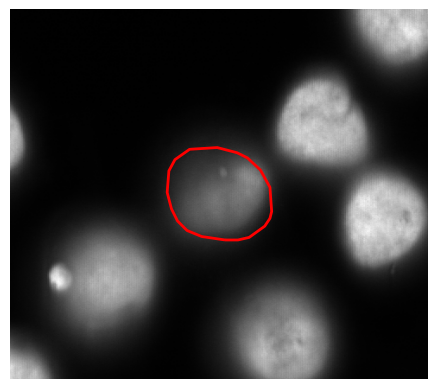

In [31]:
image_path = '/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-02-27_spatialbarcodes_SG_expression/rawData/roi_2/hyb_1_aligned.tiff'

tools.show_neighborhood(sg_obj,object_id,image_path,image_scale=3)

In [48]:
df[df['object_id'].isin(region['object_id_str'].values)][['object_id','barcode_names']+gene_names]

,object_id,barcode_names,MITF,MLANA,CAPG,TYR,OASL,IFIT2
4893,4900,bc_013-bc_023-bc_035,4.0,5.0,25.0,3.0,1.0,8.0
4988,4986,bc_013-bc_022-bc_053-bc_086-bc_088,23.0,9.0,60.0,17.0,0.0,0.0
5010,5014,bc_061-bc_073-bc_088,7.0,12.0,28.0,9.0,0.0,0.0


In [25]:
tools.get_polygons_around_polygon(sg_obj,object_id,image_scale=scale,id_field='object_id')

NameError: name 'scale' is not defined

['bc_007', 'bc_013', 'bc_017', 'bc_020', 'bc_022', 'bc_023', 'bc_024', 'bc_027', 'bc_029', 'bc_030', 'bc_035', 'bc_039', 'bc_040', 'bc_043', 'bc_047', 'bc_049', 'bc_052', 'bc_053', 'bc_056', 'bc_059', 'bc_060', 'bc_061', 'bc_064', 'bc_068', 'bc_073', 'bc_076', 'bc_077', 'bc_079', 'bc_081', 'bc_085', 'bc_086', 'bc_088', 'bc_091']
['bc_017-bc_022-bc_030-bc_039-bc_043-bc_047-bc_049-bc_052-bc_060-bc_077-bc_081'
 'bc_022' 'bc_013-bc_023-bc_035'
 'bc_013-bc_023-bc_035-bc_061-bc_073-bc_088' 'bc_013-bc_023-bc_035'
 'bc_013-bc_022-bc_053-bc_086-bc_088' 'bc_061-bc_073-bc_088'
 'bc_020-bc_059' 'bc_020-bc_059' 'bc_020-bc_059'
 'bc_007-bc_024-bc_029-bc_040-bc_056-bc_064-bc_068-bc_076-bc_079-bc_085-bc_091'
 'bc_027-bc_086']
[('bc_013', '#fdcab5'), ('bc_023', '#fc8a6a'), ('bc_035', '#f14432'), ('bc_061', '#d3eecd'), ('bc_073', '#98d594'), ('bc_088', '#4bb062'), ('bc_053', '#dadaeb'), ('bc_086', '#9e9ac8'), ('bc_022', '#686868'), ('bc_007', '#f4f4f4'), ('bc_017', '#e6e6e6'), ('bc_020', '#d4d4d4'), ('b

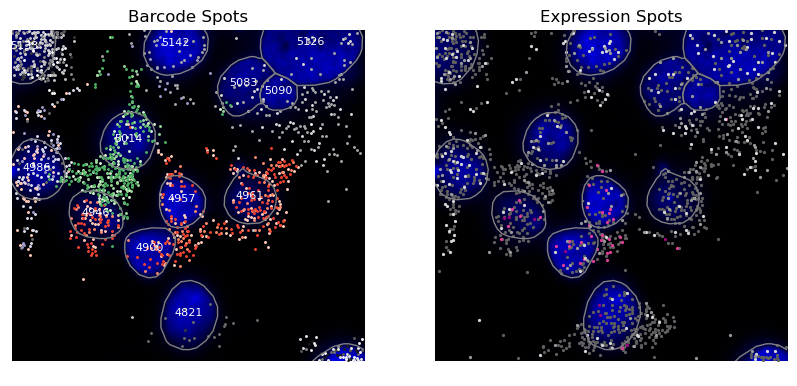

In [152]:
# clusters_of_interest = [372]
# cluster_cells = list(adata_genes[adata_genes.obs['bc_cluster']==clusters_of_interest[0]].obs['cell_id'].values)
# cluster_cells = ['37880']

scale = 1

# for object_id in ['4309']:
# for object_id in ['4900']:
# for object_id in ['4946']:
for object_id in ['4957']:

    region = tools.get_polygons_around_polygon(sg_obj,object_id,image_scale=5*scale,id_field='object_id')

    barcode_names = tools.get_all_barcodes_in_region(df,region['object_id_str'].values,id_field='object_id')
    barcode_names = list(np.unique(barcode_names))
    print(barcode_names)

    print(df[df['object_id'].isin(region['object_id_str'].values)]['barcode_names'].values)

    color_map = {
  'bc_013':sns.color_palette('Reds',4)[0],
  'bc_023':sns.color_palette('Reds',4)[1],
  'bc_035':sns.color_palette('Reds',4)[2],
                 
  'bc_061':sns.color_palette('Greens',4)[0],
  'bc_073':sns.color_palette('Greens',4)[1],
  'bc_088':sns.color_palette('Greens',4)[2],

  'bc_053':sns.color_palette('Purples',3)[0],
  'bc_086':sns.color_palette('Purples',3)[1],
  'bc_022':sns.color_palette('Greys',2)[1]
    }


    counter = 0
    for gene in barcode_names:
        if gene not in color_map.keys():
            color_map[gene] = sns.color_palette('Greys',10)[counter%10]
            counter+=1


    print([(g,matplotlib.colors.to_hex(c)) for (g,c) in color_map.items()])

    plt.figure(figsize=(10,10))

    ax = plt.subplot(1,2,1)

    region = tools.get_polygons_around_polygon(sg_obj,object_id,image_scale=scale,id_field='object_id')

    tools.plot_polygons_and_points(sg_obj,region['object_id'].values,id_field='object_id',
                                  gene_names=barcode_names,
                                   annotate=False,image_scale=scale,single_mode=False,
                                   focal_outline_color='gray',other_outline_color='gray',
                                   interior_marker='.',color_map=color_map,
                                   exterior_marker='.',marker_size=5,ax=ax,
                                   show_image=True,image_path=image_path,
                                   annotate_cells=True
                                   )

    plt.title('Barcode Spots')
    
    plt.axis('off')

    ax = plt.subplot(1,2,2)
    # gene_names = ['IGFBP7','VEGFA','MITF','COL1A1','MLANA','IFIT2','MMP1','MMP11','NANOG','BMP2']
    # color_map = {'VEGFA':sns.color_palette('Reds',3)[2],
    #              'MITF':sns.color_palette('Blues',3)[1],
    #              'IGFBP7':sns.color_palette('PuRd',3)[2],
    #              'COL1A1':'g',
    #              'IFIT2':'gold',
    #              'MMP1':'orange',
    #              'MMP11':'orange',
    #              'NANOG':'k',
    #              'BMP2':'k',
    #              'MLANA':sns.color_palette('Blues',3)[2]}
    
    cluster_genes = {0:['MITF','MLANA','CAPG'],
                    #  1:['VEGFA','NRG1','BIRC3'],
                    #  2:['COL1A1','COL5A2','BGN'],
                    #  3:['MMP11','BMP2','ROR2'],
                    #  4:['NANOG','TYR','ERBB3'],
                    #  5: ['TYR',],
                     6: ['OASL','IFIT2'],
                    #  7: ['MMP1','SERPINE1','NT5E'],
                     }
    
    cluster_colors = {
                      # 0:'Greys',
                      0:'dark:#D3D3D3',
                    #   1:'Reds',
                    #   2:'Greens',
                    #   3:'Oranges',
                    #   4:'Greys',
                      # 5:'Greys',
                      # 6:'Oranges',
                      # 6:'light:#ffbf00'
                      # 6:'Reds',
                      6:'RdPu',

                    #   7:'Purples'
                      }
    
    gene_names = [gene  for gene_list in cluster_genes.values() for gene in gene_list]

    color_map = {gene:sns.color_palette(cluster_colors[cluster],4)[3-g]  for cluster,gene_list in cluster_genes.items() for g,gene in enumerate(gene_list)}


    print([(g,matplotlib.colors.to_hex(c)) for (g,c) in color_map.items()])

    tools.plot_polygons_and_points(sg_obj,region['object_id'].values,gene_names=gene_names,
                                   annotate=False,image_scale=scale,
                                   focal_outline_color='gray',other_outline_color='gray',
                                   interior_marker='.',color_map=color_map,single_mode=False,
                                   exterior_marker='.',marker_size=7,ax=ax,
                                   show_image=True,image_path=image_path
                                   )
    
    plt.title('Expression Spots')
    
    plt.axis('off')

    plt.savefig(f'plots/figures/figure1/{object_id}_region_barcode+expression.pdf',bbox_inches='tight')
    # sg_obj_only_bcs.plot_polygon_and_points(mapping_dict[cell_id],gene_names=gene_names,annotate=False)

In [106]:
region = tools.get_polygons_around_polygon(sg_obj,object_id,image_scale=5*scale,id_field='object_id')

df[df['object_id'].isin([int(object_id)]+list(region['object_id_str'].values))][['object_id','barcode_names']+barcode_names+gene_names]

df[df['object_id'].isin([int(object_id)]+list(region['object_id_str'].values))][['object_id','barcode_names']+barcode_names+gene_names].to_clipboard()

['bc_001', 'bc_004', 'bc_007', 'bc_013', 'bc_020', 'bc_022', 'bc_025', 'bc_027', 'bc_031', 'bc_035', 'bc_039', 'bc_041', 'bc_045', 'bc_053', 'bc_063', 'bc_073', 'bc_074', 'bc_079', 'bc_084', 'bc_086', 'bc_087', 'bc_088', 'bc_091']
['bc_025-bc_031-bc_039' 'bc_020-bc_022-bc_027-bc_035-bc_041-bc_079'
 'bc_027-bc_086' 'bc_022-bc_045' 'bc_001-bc_025-bc_031-bc_039-bc_041'
 'bc_004-bc_022' 'bc_013-bc_022-bc_053-bc_063-bc_084-bc_086'
 'bc_022-bc_025-bc_031-bc_039-bc_045' 'bc_004-bc_073-bc_074-bc_088'
 'bc_001-bc_053-bc_084-bc_091' 'bc_001-bc_007-bc_027-bc_091'
 'bc_001-bc_027-bc_091' 'bc_041-bc_091' 'bc_027-bc_086' 'bc_041-bc_087'
 'bc_001-bc_041' 'bc_001-bc_007-bc_091']
[('bc_013', '#fdcab5'), ('bc_023', '#fc8a6a'), ('bc_035', '#f14432'), ('bc_061', '#d3eecd'), ('bc_073', '#98d594'), ('bc_088', '#4bb062'), ('bc_053', '#dadaeb'), ('bc_086', '#9e9ac8'), ('bc_022', '#686868'), ('bc_004', '#ffd700'), ('bc_001', '#f4f4f4'), ('bc_007', '#e6e6e6'), ('bc_020', '#d4d4d4'), ('bc_025', '#bfbfbf'), ('bc_

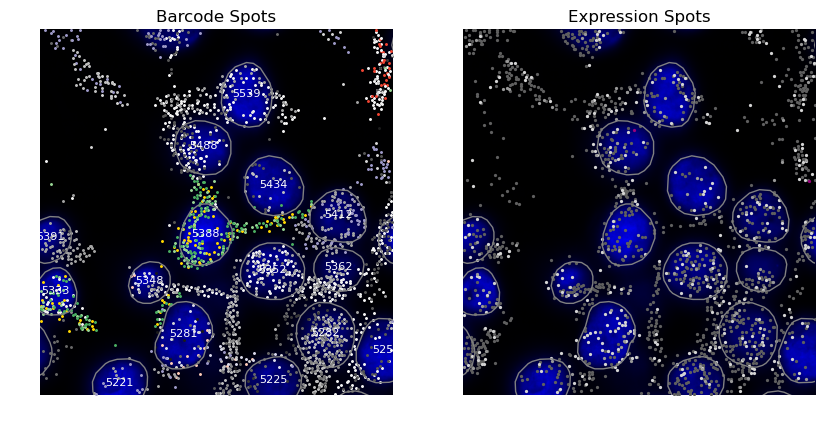

In [171]:
# clusters_of_interest = [372]
# cluster_cells = list(adata_genes[adata_genes.obs['bc_cluster']==clusters_of_interest[0]].obs['cell_id'].values)
# cluster_cells = ['37880']

scale = 1

# for object_id in ['4309']:
# for object_id in ['4900']:
# for object_id in ['4946']:
for object_id in ['5388']:

    region = tools.get_polygons_around_polygon(sg_obj,object_id,image_scale=5*scale,id_field='object_id')

    barcode_names = tools.get_all_barcodes_in_region(df,region['object_id_str'].values,id_field='object_id')
    barcode_names = list(np.unique(barcode_names))
    print(barcode_names)

    print(df[df['object_id'].isin(region['object_id_str'].values)]['barcode_names'].values)

    color_map = {
  'bc_013':sns.color_palette('Reds',4)[0],
  'bc_023':sns.color_palette('Reds',4)[1],
  'bc_035':sns.color_palette('Reds',4)[2],
                 
  'bc_061':sns.color_palette('Greens',4)[0],
  'bc_073':sns.color_palette('Greens',4)[1],
  'bc_088':sns.color_palette('Greens',4)[2],

  'bc_053':sns.color_palette('Purples',3)[0],
  'bc_086':sns.color_palette('Purples',3)[1],
  'bc_022':sns.color_palette('Greys',2)[1],

  'bc_004':'gold'
    }


    counter = 0
    for gene in barcode_names:
        if gene not in color_map.keys():
            color_map[gene] = sns.color_palette('Greys',10)[counter%10]
            counter+=1


    print([(g,matplotlib.colors.to_hex(c)) for (g,c) in color_map.items()])

    plt.figure(figsize=(10,10))

    ax = plt.subplot(1,2,1)

    region = tools.get_polygons_around_polygon(sg_obj,object_id,image_scale=scale,id_field='object_id')

    tools.plot_polygons_and_points(sg_obj,region['object_id'].values,id_field='object_id',
                                  gene_names=barcode_names,
                                   annotate=False,image_scale=scale,single_mode=False,
                                   focal_outline_color='gray',other_outline_color='gray',
                                   interior_marker='.',color_map=color_map,
                                   exterior_marker='.',marker_size=5,ax=ax,
                                   show_image=True,image_path=image_path,
                                   annotate_cells=True
                                   )

    plt.title('Barcode Spots')
    
    plt.axis('off')

    ax = plt.subplot(1,2,2)
    # gene_names = ['IGFBP7','VEGFA','MITF','COL1A1','MLANA','IFIT2','MMP1','MMP11','NANOG','BMP2']
    # color_map = {'VEGFA':sns.color_palette('Reds',3)[2],
    #              'MITF':sns.color_palette('Blues',3)[1],
    #              'IGFBP7':sns.color_palette('PuRd',3)[2],
    #              'COL1A1':'g',
    #              'IFIT2':'gold',
    #              'MMP1':'orange',
    #              'MMP11':'orange',
    #              'NANOG':'k',
    #              'BMP2':'k',
    #              'MLANA':sns.color_palette('Blues',3)[2]}
    
    cluster_genes = {0:['MITF','MLANA','CAPG'],
                    #  1:['VEGFA','NRG1','BIRC3'],
                    #  2:['COL1A1','COL5A2','BGN'],
                    #  3:['MMP11','BMP2','ROR2'],
                    #  4:['NANOG','TYR','ERBB3'],
                    #  5: ['TYR',],
                     6: ['OASL','IFIT2'],
                    #  7: ['MMP1','SERPINE1','NT5E'],
                     }
    
    cluster_colors = {
                      # 0:'Greys',
                      0:'dark:#D3D3D3',
                    #   1:'Reds',
                    #   2:'Greens',
                    #   3:'Oranges',
                    #   4:'Greys',
                      # 5:'Greys',
                      # 6:'Oranges',
                      # 6:'light:#ffbf00'
                      # 6:'Reds',
                      6:'RdPu',

                    #   7:'Purples'
                      }
    
    gene_names = [gene  for gene_list in cluster_genes.values() for gene in gene_list]

    color_map = {gene:sns.color_palette(cluster_colors[cluster],4)[3-g]  for cluster,gene_list in cluster_genes.items() for g,gene in enumerate(gene_list)}


    print([(g,matplotlib.colors.to_hex(c)) for (g,c) in color_map.items()])

    tools.plot_polygons_and_points(sg_obj,region['object_id'].values,gene_names=gene_names,
                                   annotate=False,image_scale=scale,
                                   focal_outline_color='gray',other_outline_color='gray',
                                   interior_marker='.',color_map=color_map,single_mode=False,
                                   exterior_marker='.',marker_size=7,ax=ax,
                                   show_image=True,image_path=image_path
                                   )
    
    plt.title('Expression Spots')
    
    plt.axis('off')

    # plt.savefig(f'plots/figures/figure1/{object_id}_region_barcode+expression.pdf',bbox_inches='tight')
    # sg_obj_only_bcs.plot_polygon_and_points(mapping_dict[cell_id],gene_names=gene_names,annotate=False)

['bc_001', 'bc_004', 'bc_007', 'bc_013', 'bc_014', 'bc_020', 'bc_022', 'bc_023', 'bc_024', 'bc_027', 'bc_029', 'bc_033', 'bc_035', 'bc_040', 'bc_041', 'bc_053', 'bc_056', 'bc_058', 'bc_059', 'bc_064', 'bc_068', 'bc_073', 'bc_074', 'bc_076', 'bc_079', 'bc_082', 'bc_083', 'bc_085', 'bc_086', 'bc_087', 'bc_088', 'bc_090', 'bc_091', 'bc_093', 'bc_094']
['bc_013-bc_022-bc_053-bc_086' 'bc_020-bc_059' 'bc_020-bc_059' 'bc_022'
 'bc_020-bc_059'
 'bc_007-bc_024-bc_029-bc_040-bc_056-bc_064-bc_068-bc_076-bc_079-bc_085-bc_091'
 'bc_027-bc_086' 'bc_086' 'bc_091' 'bc_027-bc_086'
 'bc_007-bc_029-bc_040-bc_064-bc_085-bc_091'
 'bc_007-bc_013-bc_022-bc_023-bc_035-bc_079-bc_091' 'bc_004-bc_022'
 'bc_024-bc_056' 'bc_004-bc_073-bc_074-bc_088'
 'bc_001-bc_014-bc_020-bc_027-bc_088-bc_090-bc_093'
 'bc_004-bc_073-bc_074-bc_088'
 'bc_001-bc_004-bc_014-bc_020-bc_027-bc_041-bc_087-bc_088-bc_090-bc_093'
 'bc_041-bc_091'
 'bc_007-bc_024-bc_033-bc_041-bc_056-bc_058-bc_076-bc_083-bc_094'
 'bc_033-bc_076-bc_087' 'bc_04

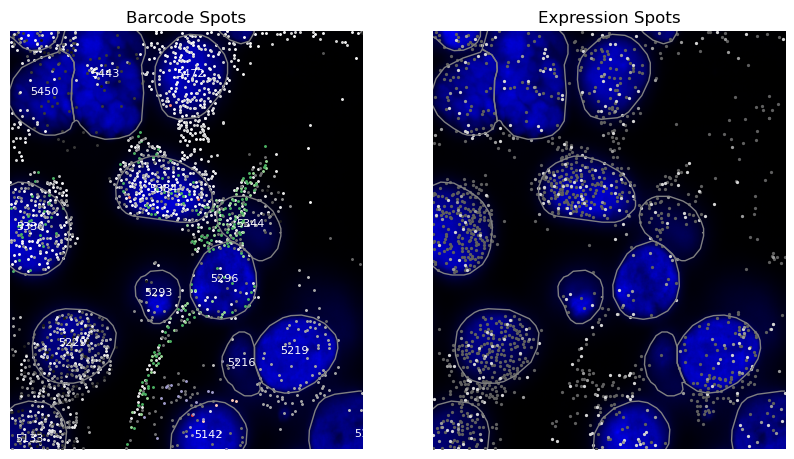

In [169]:
# clusters_of_interest = [372]
# cluster_cells = list(adata_genes[adata_genes.obs['bc_cluster']==clusters_of_interest[0]].obs['cell_id'].values)
# cluster_cells = ['37880']

scale = 1.5

# for object_id in ['4309']:
# for object_id in ['4900']:
# for object_id in ['4946']:
for object_id in ['5344']:

    region = tools.get_polygons_around_polygon(sg_obj,object_id,image_scale=5*scale,id_field='object_id')

    barcode_names = tools.get_all_barcodes_in_region(df,region['object_id_str'].values,id_field='object_id')
    barcode_names = list(np.unique(barcode_names))
    print(barcode_names)

    print(df[df['object_id'].isin(region['object_id_str'].values)]['barcode_names'].values)

    color_map = {
  'bc_013':sns.color_palette('Reds',4)[0],
  'bc_023':sns.color_palette('Reds',4)[1],
  'bc_035':sns.color_palette('Reds',4)[2],
                 
  'bc_061':sns.color_palette('Greens',4)[0],
  'bc_073':sns.color_palette('Greens',4)[1],
  'bc_088':sns.color_palette('Greens',4)[2],

  'bc_053':sns.color_palette('Purples',3)[0],
  'bc_086':sns.color_palette('Purples',3)[1],
  'bc_022':sns.color_palette('Greys',2)[1]
    }


    counter = 0
    for gene in barcode_names:
        if gene not in color_map.keys():
            color_map[gene] = sns.color_palette('Greys',10)[counter%10]
            counter+=1


    print([(g,matplotlib.colors.to_hex(c)) for (g,c) in color_map.items()])

    plt.figure(figsize=(10,10))

    ax = plt.subplot(1,2,1)

    region = tools.get_polygons_around_polygon(sg_obj,object_id,image_scale=scale,id_field='object_id')

    tools.plot_polygons_and_points(sg_obj,region['object_id'].values,id_field='object_id',
                                  gene_names=barcode_names,
                                   annotate=False,image_scale=scale,single_mode=False,
                                   focal_outline_color='gray',other_outline_color='gray',
                                   interior_marker='.',color_map=color_map,
                                   exterior_marker='.',marker_size=5,ax=ax,
                                   show_image=True,image_path=image_path,
                                   annotate_cells=True
                                   )

    plt.title('Barcode Spots')
    
    plt.axis('off')

    ax = plt.subplot(1,2,2)
    # gene_names = ['IGFBP7','VEGFA','MITF','COL1A1','MLANA','IFIT2','MMP1','MMP11','NANOG','BMP2']
    # color_map = {'VEGFA':sns.color_palette('Reds',3)[2],
    #              'MITF':sns.color_palette('Blues',3)[1],
    #              'IGFBP7':sns.color_palette('PuRd',3)[2],
    #              'COL1A1':'g',
    #              'IFIT2':'gold',
    #              'MMP1':'orange',
    #              'MMP11':'orange',
    #              'NANOG':'k',
    #              'BMP2':'k',
    #              'MLANA':sns.color_palette('Blues',3)[2]}
    
    cluster_genes = {0:['MITF','MLANA','CAPG'],
                    #  1:['VEGFA','NRG1','BIRC3'],
                    #  2:['COL1A1','COL5A2','BGN'],
                    #  3:['MMP11','BMP2','ROR2'],
                    #  4:['NANOG','TYR','ERBB3'],
                    #  5: ['TYR',],
                     6: ['OASL','IFIT2'],
                    #  7: ['MMP1','SERPINE1','NT5E'],
                     }
    
    cluster_colors = {
                      # 0:'Greys',
                      0:'dark:#D3D3D3',
                    #   1:'Reds',
                    #   2:'Greens',
                    #   3:'Oranges',
                    #   4:'Greys',
                      # 5:'Greys',
                      # 6:'Oranges',
                      # 6:'light:#ffbf00'
                      # 6:'Reds',
                      6:'RdPu',

                    #   7:'Purples'
                      }
    
    gene_names = [gene  for gene_list in cluster_genes.values() for gene in gene_list]

    color_map = {gene:sns.color_palette(cluster_colors[cluster],4)[3-g]  for cluster,gene_list in cluster_genes.items() for g,gene in enumerate(gene_list)}


    print([(g,matplotlib.colors.to_hex(c)) for (g,c) in color_map.items()])

    tools.plot_polygons_and_points(sg_obj,region['object_id'].values,gene_names=gene_names,
                                   annotate=False,image_scale=scale,
                                   focal_outline_color='gray',other_outline_color='gray',
                                   interior_marker='.',color_map=color_map,single_mode=False,
                                   exterior_marker='.',marker_size=7,ax=ax,
                                   show_image=True,image_path=image_path
                                   )
    
    plt.title('Expression Spots')
    
    plt.axis('off')

    # plt.savefig(f'plots/figures/figure1/{object_id}_region_barcode+expression.pdf',bbox_inches='tight')
    # sg_obj_only_bcs.plot_polygon_and_points(mapping_dict[cell_id],gene_names=gene_names,annotate=False)

In [43]:
df[df['object_id'].isin(region['object_id_str'].values)][gene_names].sum()

MITF       34.0
MLANA      26.0
CAPG      113.0
ITGA8       0.0
TYR        29.0
SLC7A8      9.0
OASL        1.0
IFIT2       8.0
RIGI        3.0
dtype: float32

In [61]:
sg_obj.gdf.geometry.centroid.x

0         9310.387401
1         6475.858987
2        24695.070940
3        11512.465373
4        14620.955252
             ...     
16371    19899.600923
16372    20379.340863
16373    22879.828744
16374    24816.055802
16375    12979.796910
Length: 16376, dtype: float64

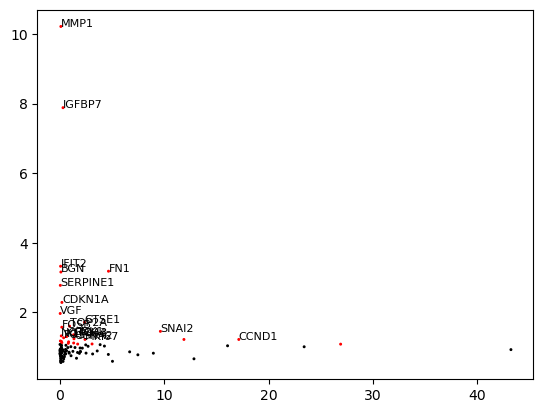

In [27]:
# for entry in adata_genes.var

color_dict = {True:'r',False:'k'}

plt.figure()

plt.scatter(adata_genes.var['means'].values,adata_genes.var['variances_norm'].values,
            marker='.',s=5,color=[color_dict[x] for x in adata_genes.var['highly_variable']])

for gene in adata_genes.var.index:
    if adata_genes.var['highly_variable_rank'].loc[gene] < 20:
        plt.text(adata_genes.var['means'].loc[gene],adata_genes.var['variances_norm'].loc[gene],gene,fontsize=8)

/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


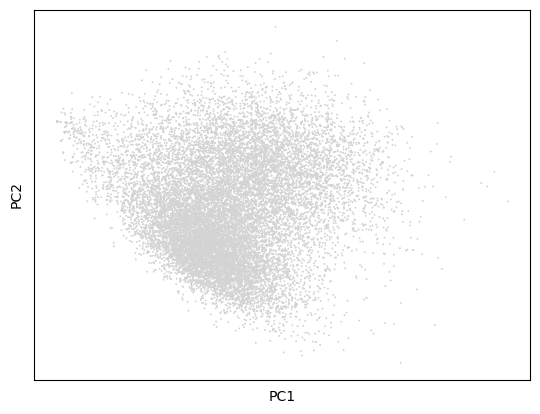

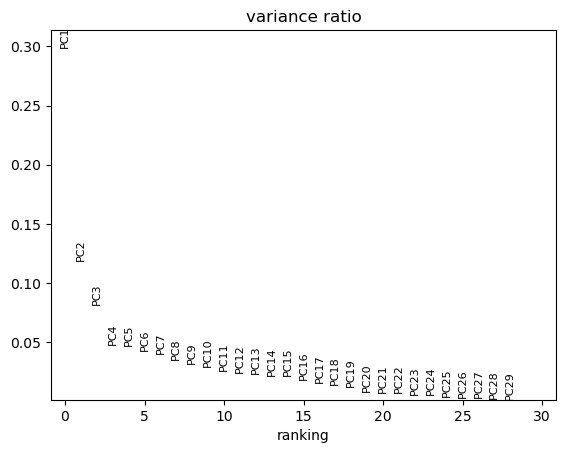

In [28]:
sc.pp.pca(adata_genes)
sc.pl.pca(adata_genes)
sc.pl.pca_variance_ratio(adata_genes, log=False)

In [29]:
sc.pp.neighbors(adata_genes)

In [30]:
# sc.pp.scale(adata_genes)
sc.tl.umap(adata_genes)
sc.tl.leiden(adata_genes, n_iterations=-1)

/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


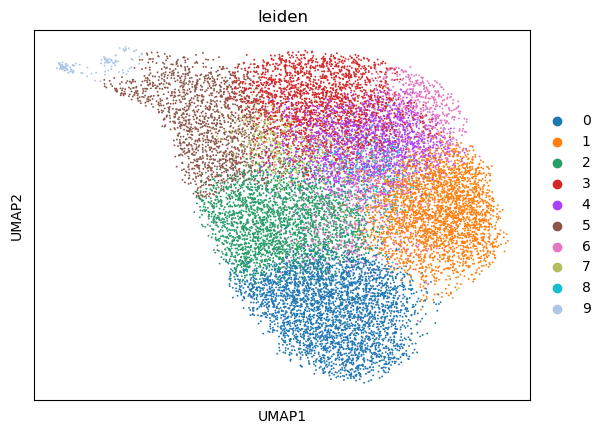

In [31]:
sc.pl.umap(adata_genes, color=["leiden"])

ok, so now we have a UMAP with clusters of the cells. We can now ask whether sisters are closer to each other in this space than expected by chance.

/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


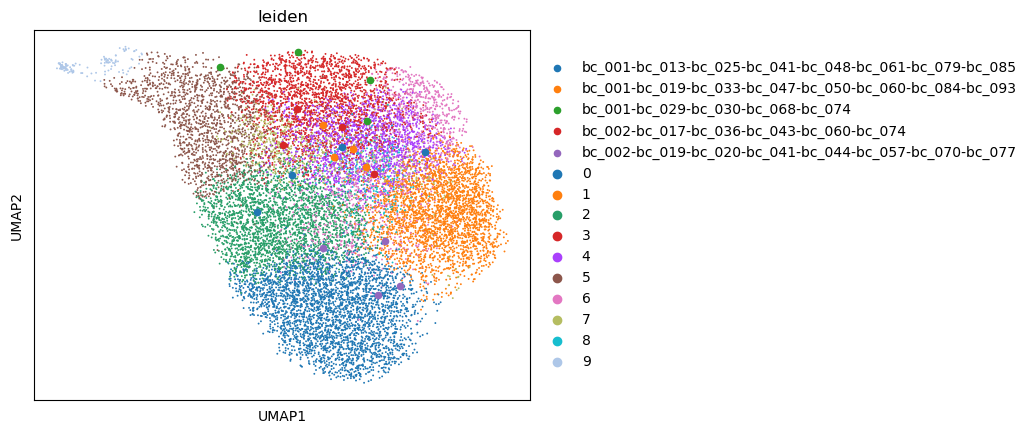

In [32]:
fig,ax = plt.subplots()
for b,(bc_set,ix) in enumerate(sister_cells.items()):
    if b < 5:
        umap_coords = adata_genes[ix].obsm['X_umap']
        ax.scatter(umap_coords[:,0],umap_coords[:,1],s=20,zorder=10,label=bc_set) 
sc.pl.umap(adata_genes, color=["leiden"],ax=ax)

 

it sort of appears that sisters are closer to each other. However, we haven't yet accounted for cell cycle, which could make sisters look more different from each other by itself.

In [33]:
cell_cycle_genes = [x.strip() for x in open('../data/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata_genes.var_names]

In [34]:
sc.tl.score_genes(adata_genes,cell_cycle_genes,score_name='g2m_score')

/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


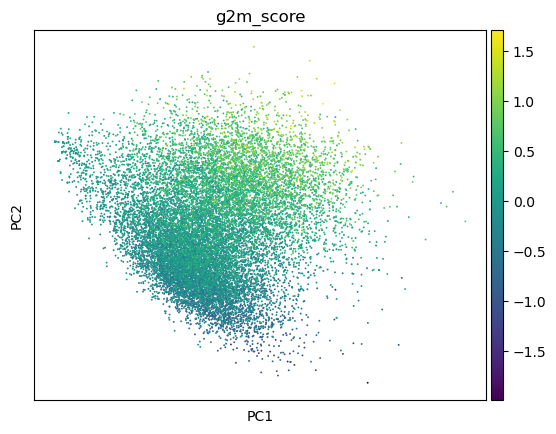

In [40]:
sc.pl.pca(adata_genes,color='g2m_score')

cell cycle does strongly correlated with the first 2 pcs. we can now regress this out.

In [36]:
sc.pp.regress_out(adata_genes, ['g2m_score'])
sc.pp.scale(adata_genes)

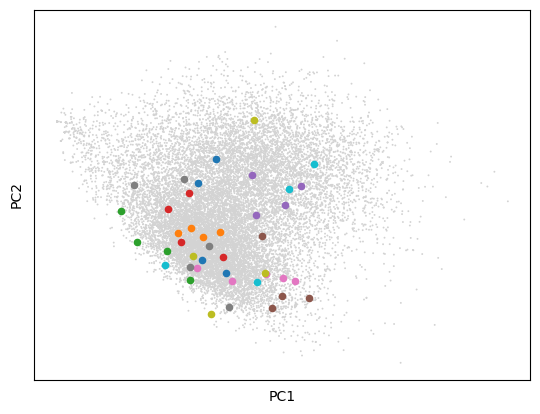

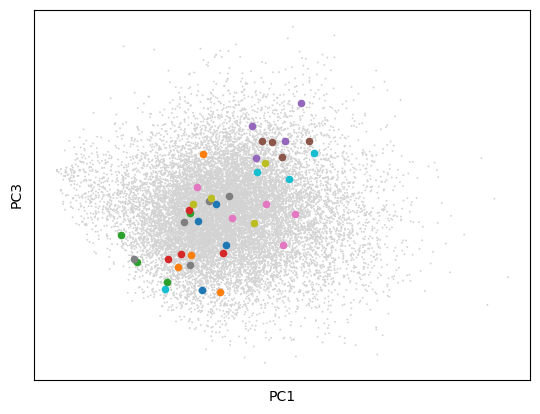

In [38]:
fig,ax = plt.subplots()
for b,(bc_set,ix) in enumerate(sister_cells.items()):
    if b < 10:
        pca_coords = adata_genes[ix].obsm['X_pca']
        ax.scatter(pca_coords[:,0],pca_coords[:,1],s=20,zorder=10,label=bc_set) 

sc.pl.pca(adata_genes,ax=ax,components='1,2')


fig,ax = plt.subplots()
for b,(bc_set,ix) in enumerate(sister_cells.items()):
    if b < 10:
        pca_coords = adata_genes[ix].obsm['X_pca']
        ax.scatter(pca_coords[:,0],pca_coords[:,2],s=20,zorder=10,label=bc_set) 

sc.pl.pca(adata_genes,ax=ax,components='1,3')
# ax.legend()
# fig.savefig('pca_sister_cells_G2Mregressed.pdf',bbox_inches='tight')
# fig.savefig('pca_sister_cells_G2Mregressed.png',dpi=300,bbox_inches='tight')

by eye, it definitely looks like sisters are very close in this space. let's see what happens when we 

In [220]:
sister_cells_more = {}
for bc_set in np.unique(df[df['n_called_barcodes']>3]['barcode_names'].values):
    if len(df[df['barcode_names']==bc_set]) > 1:

        sister_cells_more[bc_set] = df[df['barcode_names']==bc_set]['object_id_x'].values


sisterhood_by_cell_ix = {i:bc_set for bc_set,ix in sister_cells_more.items() for i in ix}
sister_ids_by_cell_ix = {i:list(sister_cells_more[bc_set]) for bc_set,ix in sister_cells_more.items() for i in ix}

In [221]:
df[df['barcode_names']==bc_set]

,object_id_x,AKT1,AXL,BGN,BIRC3,BIRC5,BMP2,BMP4,CALD1,CAPG,...,bc_095,bc_096,cell_id,called_barcodes,n_called_barcodes,barcode_names,object_id_y,nucleus,nucleus_centroid,object_id_str
1569,1568,5.0,0.0,0.0,0.0,4.0,0.0,0.0,5.0,41.0,...,0.0,0.0,1568,"[bc_083, bc_085, bc_089, bc_092]",4,bc_083-bc_085-bc_089-bc_092,1568,"POLYGON ((25133.000 3906.000, 25173.000 3908.0...",POINT (25146.866 3961.561),1568


In [196]:
sister_cells_more

{'bc_001-bc_002-bc_028-bc_067-bc_081-bc_095': Int64Index([14298, 14326], dtype='int64'),
 'bc_001-bc_002-bc_030-bc_041-bc_043-bc_083': Int64Index([8154, 8268], dtype='int64'),
 'bc_001-bc_002-bc_030-bc_041-bc_083': Int64Index([8129, 8302], dtype='int64'),
 'bc_001-bc_002-bc_060-bc_091': Int64Index([7279, 7637, 7688], dtype='int64'),
 'bc_001-bc_003-bc_006-bc_060-bc_064-bc_070': Int64Index([10709, 10778, 11049], dtype='int64'),
 'bc_001-bc_003-bc_008-bc_047-bc_092': Int64Index([5235, 5284, 5696], dtype='int64'),
 'bc_001-bc_003-bc_011-bc_059-bc_078-bc_094-bc_095': Int64Index([15255, 15280], dtype='int64'),
 'bc_001-bc_003-bc_022-bc_068-bc_090': Int64Index([11344, 11389], dtype='int64'),
 'bc_001-bc_003-bc_035-bc_058-bc_070-bc_092': Int64Index([5141, 5172, 5274], dtype='int64'),
 'bc_001-bc_004-bc_005-bc_009-bc_038-bc_066': Int64Index([10169, 10211], dtype='int64'),
 'bc_001-bc_004-bc_009-bc_038-bc_066': Int64Index([10232, 10306], dtype='int64'),
 'bc_001-bc_004-bc_025-bc_060-bc_076-bc_0

In [186]:

centroid_array = np.stack(sg_obj.gdf['nucleus_centroid'].apply(lambda x: np.array(x.coords).ravel()))

distance_matrix = scipy.spatial.distance.pdist(centroid_array)
square_distance_matrix =scipy.spatial.distance.squareform(distance_matrix)

# get neighbors of a focal cell


def find_neighbors(ix,distance_matrix,threshold):
    # ix = df.index
    # this_ix = np.where(df['cell_id'] == cell_id)[0][0]

    # print(this_ix)
    neighbor_ix  = np.where(distance_matrix[ix,:] < threshold)[0]
    neighbor_ix = neighbor_ix[neighbor_ix != ix]    

    # neighbors = [x for x in df['cell_id'].values[neighbor_ix] if x !=cell_id]
     
    return neighbor_ix

def find_non_sister_neighbors(ix,sisters,distance_matrix,threshold):
    neighbors = find_neighbors(ix,distance_matrix,threshold)
    non_sister_neighbors = [x for x in neighbors if x not in sisters]
    return non_sister_neighbors


def find_neighbors_by_cell_id(cell_id,df,distance_matrix,threshold):
    # ix = df.index
    this_ix = np.where(df['cell_id'] == cell_id)[0][0]

    # print(this_ix)
    neighbor_ix  = np.where(distance_matrix[this_ix,:] < threshold)[0]

    neighbors = [x for x in df['cell_id'].values[neighbor_ix] if x!=cell_id]
     
    return neighbors




In [222]:
sister_more_dists = []
randos = []
neighbors= []
non_sister_neighbors = []

neighbor_distance = 3000

# all_ids = df.index
# all_ids = range(len(df))
all_ids = range(len(adata_genes))

pcs_to_use = 10

for b,(bc_set,ix) in enumerate(sister_cells_more.items()):
    # if b < 10:
    print(ix)
    print(list(ix))

    pca_coords = adata_genes[list(ix)].obsm['X_pca']

    d = scipy.spatial.distance.pdist(pca_coords[:,:pcs_to_use]) # calculate distance using top 20 PCs
    sister_more_dists.append(np.mean(d))

    print('1')


    pca_coords = adata_genes[np.random.choice(all_ids,len(ix))].obsm['X_pca']
    d = scipy.spatial.distance.pdist(pca_coords[:,:pcs_to_use]) # calculate distance using top 20 PCs
    randos.append(np.mean(d))

    print('2')

    random_cell = np.random.choice(all_ids,1)[0]
    these_neighbors = find_neighbors(random_cell,square_distance_matrix,neighbor_distance)
    pca_coords = adata_genes[np.random.choice(these_neighbors,len(ix))].obsm['X_pca']
    d = scipy.spatial.distance.pdist(pca_coords[:,:pcs_to_use]) # calculate distance using top 20 PCs
    neighbors.append(np.mean(d))

    print('3')

    # random_cell = np.random.choice(all_ids,1)[0]
    # if random_cell in sisterhood_by_cell_ix:
    #     these_neighbors = find_non_sister_neighbors(random_cell,sister_ids_by_cell_ix[random_cell],square_distance_matrix,neighbor_distance)
    # else:   
    #     these_neighbors = find_neighbors(random_cell,square_distance_matrix,neighbor_distance)
    # pca_coords = adata_genes[np.random.choice(these_neighbors,len(ix))].obsm['X_pca']
    # d = scipy.spatial.distance.pdist(pca_coords[:,:pcs_to_use]) # calculate distance using top 20 PCs
    # non_sister_neighbors.append(np.mean(d))
    

        # neighbors = find_non_sister_neighbors(random_cell,ix,df,square_distance_matrix,2000)





# n_sims = 1000

# randos = np.zeros((n_sims,len(sister_cells_more)))

# for n in range(n_sims):
#     for b,(bc_set,ix) in enumerate(sister_cells_more.items()):
#         # if b < 10:
#             # pca_coords = adata_genes[ix].obsm['X_pca']

#             # d = scipy.spatial.distance.pdist(pca_coords[:,:pcs_to_use]) # caluclate distance using top 20 PCs
#             # sister_more_dists.append(np.mean(d))


#             pca_coords = adata_genes[np.random.choice(all_ids,len(ix))].obsm['X_pca']
#             d = scipy.spatial.distance.pdist(pca_coords[:,:pcs_to_use]) # caluclate distance using top 20 PCs
#             randos[n,b] = np.mean(d)






[14314 14336]
[14314, 14336]
1
2
3
[8159 8265]
[8159, 8265]
1
2
3
[8128 8301]
[8128, 8301]
1
2
3
[7282 7648 7687]
[7282, 7648, 7687]
1
2
3
[10714 10782 11050]
[10714, 10782, 11050]
1
2
3
[5232 5290 5681]
[5232, 5290, 5681]
1
2
3
[15254 15280]
[15254, 15280]
1
2
3
[11344 11380]
[11344, 11380]
1
2
3
[5145 5170 5261]
[5145, 5170, 5261]
1
2
3
[10179 10208]
[10179, 10208]
1
2
3
[10235 10308]
[10235, 10308]
1
2
3
[4469 4579]
[4469, 4579]
1
2
3
[5600 5648]
[5600, 5648]
1
2
3
[4623 5226]
[4623, 5226]
1
2
3
[7753 7786]
[7753, 7786]
1
2
3
[235 240 293]
[235, 240, 293]
1
2
3
[4781 4789]
[4781, 4789]
1
2
3
[5303 5380]
[5303, 5380]
1
2
3
[3242 3314]
[3242, 3314]
1
2
3
[465 586]
[465, 586]
1
2
3
[395 438]
[395, 438]
1
2
3
[6024 6033 6131]
[6024, 6033, 6131]
1
2
3
[400 488]
[400, 488]
1
2
3
[7342 7575]
[7342, 7575]
1
2
3
[9026 9082]
[9026, 9082]
1
2
3
[6833 6920]
[6833, 6920]
1
2
3
[8704 8757]
[8704, 8757]
1
2
3
[13887 14085]
[13887, 14085]
1
2
3
[7685 7749 7944]
[7685, 7749, 7944]
1
2
3
[8747 8893]


IndexError: positional indexers are out-of-bounds

In [217]:
len(adata_genes)

16328

Text(0.5, 0, 'Mean distance between sisters')

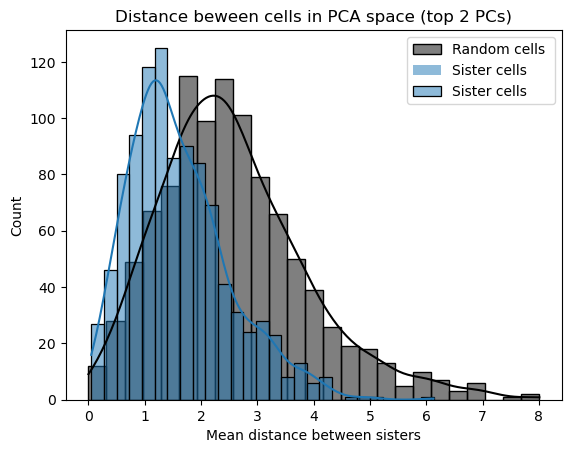

In [43]:
fig,ax = plt.subplots()
sns.histplot(randos,ax=ax,color='k',kde=True,alpha=0.5,label='Random cells ')
sns.histplot(sister_more_dists,ax=ax,kde=True,alpha=0.5,label='Sister cells')
# sns.kdeplot(randos,ax=ax,color='gray',alpha=0.5)
# sns.kdeplot(sister_more_dists,ax=ax,alpha=0.5)
plt.legend()
plt.title(f'Distance beween cells in PCA space (top {pcs_to_use} PCs)')
plt.xlabel('Mean distance between sisters')
# plt.savefig(f'sister_cell_distances_withrandom_{pcs_to_use}PCs.pdf',bbox_inches='tight')



Text(0.5, 0, 'Mean distance between sisters')

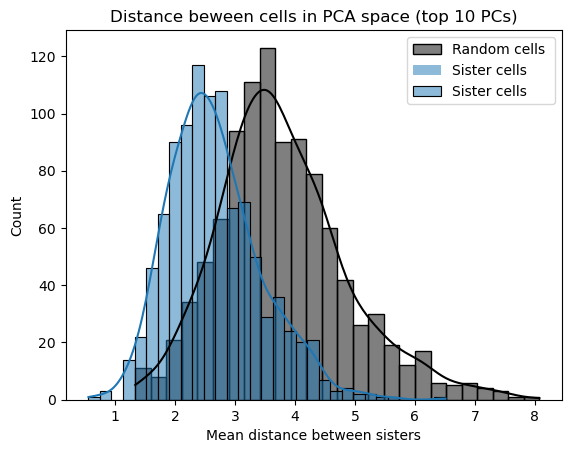

In [46]:
fig,ax = plt.subplots()
sns.histplot(randos,ax=ax,color='k',kde=True,alpha=0.5,label='Random cells ')
sns.histplot(sister_more_dists,ax=ax,kde=True,alpha=0.5,label='Sister cells')
# sns.kdeplot(randos,ax=ax,color='gray',alpha=0.5)
# sns.kdeplot(sister_more_dists,ax=ax,alpha=0.5)
plt.legend()
plt.title(f'Distance beween cells in PCA space (top {pcs_to_use} PCs)')
plt.xlabel('Mean distance between sisters')
# plt.savefig(f'sister_cell_distances_withrandom_{pcs_to_use}PCs.pdf',bbox_inches='tight')



how does this change as a function of how many sisters there are? In general, we should expect that sisterhoods of larger sizes should be more like random, as memory becomes diluted over cell divisions. 

In [47]:
n_sisters  = []
sister_more_dists = []

for b,(bc_set,ix) in enumerate(sister_cells_more.items()):
    # if b < 10:
        pca_coords = adata_genes[ix].obsm['X_pca']

        d = scipy.spatial.distance.pdist(pca_coords[:,:pcs_to_use]) # caluclate distance using top 20 PCs
        sister_more_dists.append(np.mean(d))
        n_sisters.append(len(ix))


        # pca_coords = adata_genes[np.random.choice(all_ids,len(ix))].obsm['X_pca']
        # d = scipy.spatial.distance.pdist(pca_coords[:,:pcs_to_use]) # caluclate distance using top 20 PCs
        # randos.append(np.mean(d))

Text(0.5, 0, 'Mean distance between sisters')

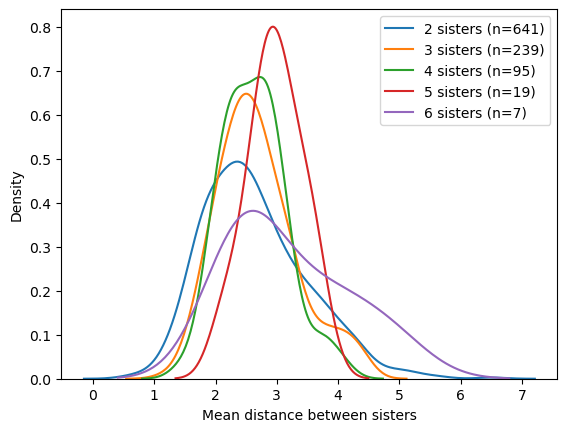

In [50]:
for n in [2,3,4,5,6]:
    # locations with this many sisters
    ix = np.where(np.array(n_sisters) == n)[0]
    sister_dists_here = [sister_more_dists[i] for i in ix]
    # sns.histplot(sister_dists_here,label=n,stat='density')
    sns.kdeplot(sister_dists_here,label=f'{n} sisters (n={len(sister_dists_here)})')
plt.legend()
plt.xlabel('Mean distance between sisters')

indeed, sisterhoods of 2 have the most similar 

In [81]:
# get distances between the nuclei of all cells
distance_matrix = scipy.spatial.distance.pdist(df['nucleus_centroid'].values)

ValueError: A 2-dimensional array must be passed.

In [80]:
sg_obj.gdf['nucleus_centroid'].distance()

TypeError: distance() missing 1 required positional argument: 'other'

In [88]:
sg_obj.gdf['nucleus_centroid']

0             POINT (9310.387 8.913)
1            POINT (6475.859 12.348)
2           POINT (24695.071 14.397)
3           POINT (11512.465 18.850)
4           POINT (14620.955 16.886)
                    ...             
16371    POINT (19899.601 35594.028)
16372    POINT (20379.341 35601.878)
16373    POINT (22879.829 35591.004)
16374    POINT (24816.056 35588.584)
16375    POINT (12979.797 35592.946)
Name: nucleus_centroid, Length: 16376, dtype: geometry

In [172]:
find_neighbors(100,df,square_distance_matrix,100)

[73, 101]

In [156]:
df

,object_id_x,AKT1,AXL,BGN,BIRC3,BIRC5,BMP2,BMP4,CALD1,CAPG,...,bc_095,bc_096,cell_id,called_barcodes,n_called_barcodes,barcode_names,object_id_y,nucleus,nucleus_centroid,object_id_str
0,35,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,...,0.0,0.0,35,[],0,,35,"POLYGON ((9279.000 2.000, 9349.000 3.000, 9356...",POINT (9310.387 8.913),35
1,34,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,...,0.0,0.0,34,[bc_030],1,bc_030,34,"POLYGON ((6437.000 2.000, 6520.000 2.000, 6527...",POINT (6475.859 12.348),34
2,29,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,9.0,...,0.0,0.0,29,[bc_078],1,bc_078,29,"POLYGON ((24636.000 0.000, 24762.000 0.000, 24...",POINT (24695.071 14.397),29
3,11,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,7.0,...,0.0,0.0,11,[],0,,11,"POLYGON ((11474.000 0.000, 11542.000 0.000, 11...",POINT (11512.465 18.850),11
4,15,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,14.0,...,0.0,0.0,15,"[bc_018, bc_060]",2,bc_018-bc_060,15,"POLYGON ((14595.000 0.000, 14678.000 2.000, 14...",POINT (14620.955 16.886),15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16371,16364,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,8.0,...,8.0,0.0,16364,"[bc_035, bc_066, bc_095]",3,bc_035-bc_066-bc_095,16364,"POLYGON ((19896.000 35571.000, 19914.000 35571...",POINT (19899.601 35594.028),16364
16372,16375,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,16375,[],0,,16375,"POLYGON ((20380.000 35592.000, 20408.000 35596...",POINT (20379.341 35601.878),16375
16373,16361,2.0,0.0,0.0,0.0,2.0,0.0,0.0,4.0,12.0,...,0.0,0.0,16361,"[bc_019, bc_030, bc_085]",3,bc_019-bc_030-bc_085,16361,"POLYGON ((22881.000 35565.000, 22904.000 35566...",POINT (22879.829 35591.004),16361
16374,16357,1.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,9.0,...,0.0,0.0,16357,"[bc_012, bc_022, bc_055]",3,bc_012-bc_022-bc_055,16357,"POLYGON ((24819.000 35560.000, 24840.000 35560...",POINT (24816.056 35588.584),16357


In [101]:
np.where(square_distance_matrix[1,:] < 1000)

(array([  1,  14,  16,  41,  44,  56,  72,  83,  87,  99, 102, 133, 139,
        141, 163, 174, 190, 199, 219, 251, 267, 280, 305, 331, 334, 382]),)

In [104]:
find_neighbors(,)

(16376, 221)

In [107]:
square_distance_matrix.shape

(16376, 16376)